# Analysis

This notebook shows the data analysis done to better understand the data and find possible data correlations, opportunities for data featuring, outliers, etc.

The output are already done after each box of commands. If needed, they can be run all again, using the menu CELL->RUN ALL

In [1]:
%pylab inline
import sklearn
import pandas as pd
from mylib import utils as mu

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline
# seaborn stuff
import seaborn as sns
sns.set(style="darkgrid", rc={"figure.figsize": (15, 10)})
colors = ['pale red', 'medium green']
myPalette = sns.xkcd_palette(colors)

## Load data and preprocess

The basic process was to load the data, join the application data with the loan data. Empty cells were found only on **other_phone_type, bank_account_duration, Occupation**

In [3]:
# load the datasets
application_raw = pd.read_excel('./input/onsite homework v1.xlsx', 1)
loan_raw = pd.read_excel('./input/onsite homework v1.xlsx', 2)
print('Loaded information. Loan #: %d Applications #:%d' %(loan_raw.index.size, application_raw.index.size))
print 'Application Format:', application_raw.shape 
print 'Loan Format:', loan_raw.shape 

Loaded information. Loan #: 1285 Applications #:647
Application Format: (647, 34)
Loan Format: (1285, 2)


In [4]:
# create the customer id on loan to join with application
print('Creating customer_id field to join loan and application')
loan = loan_raw.copy()
loan['customer_id']=loan.apply(lambda l: l[0][:-3].lower(), axis = 1)
loan['loan_no']=loan.apply(lambda l: int(l[0][-2:]), axis = 1)

Creating customer_id field to join loan and application


In [5]:
# found that there is 16 with 2 loans. will keep only the second
idx_more_than_once = (loan.groupby(['customer_id'])['flgGood'].count() >1)
idx_more_than_once = idx_more_than_once[idx_more_than_once == True]
print('Number of clients with 2 loans %d' %idx_more_than_once.count())
print('Removing first loan. Nr of lines %d' % loan.idLoan.count())
loan.drop(loan[loan.customer_id.isin(idx_more_than_once.index)][loan.loan_no ==1].index, inplace = True)
print('After removal. Nr of lines %d' %loan.idLoan.count())

Number of clients with 2 loans 16
Removing first loan. Nr of lines 1285
After removal. Nr of lines 1269


/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [6]:
# preprocess application
print('Preprocessing application')
application = application_raw.copy()

# create data 
data = pd.merge(application, loan, on='customer_id')
print('Final data created. Nr of lines %d' %data.index.size)

# 13 lines lost. Check if it is correct
print('Number of lines discarded %d' 
      %application[~application.customer_id.isin(data.customer_id)].customer_id.count())

Preprocessing application
Final data created. Nr of lines 634
Number of lines discarded 13


In [7]:
# feature creations
# fill the secondary type with string NI - Not Informed
data.other_phone_type.fillna('NI', inplace=True)
data.bank_account_duration.fillna('NI', inplace=True)
data.Occupation.fillna('NI', inplace=True)

# transform date of birth to age
data['age'] = data.birth_date.apply(mu.years_passed)
data['application_age'] = data.application_when.apply(mu.days_passed)

## Analysis expected trends

As this is a "real" data some may patterns could be truth, like better wages, less default, etc. Let's see if that stands.

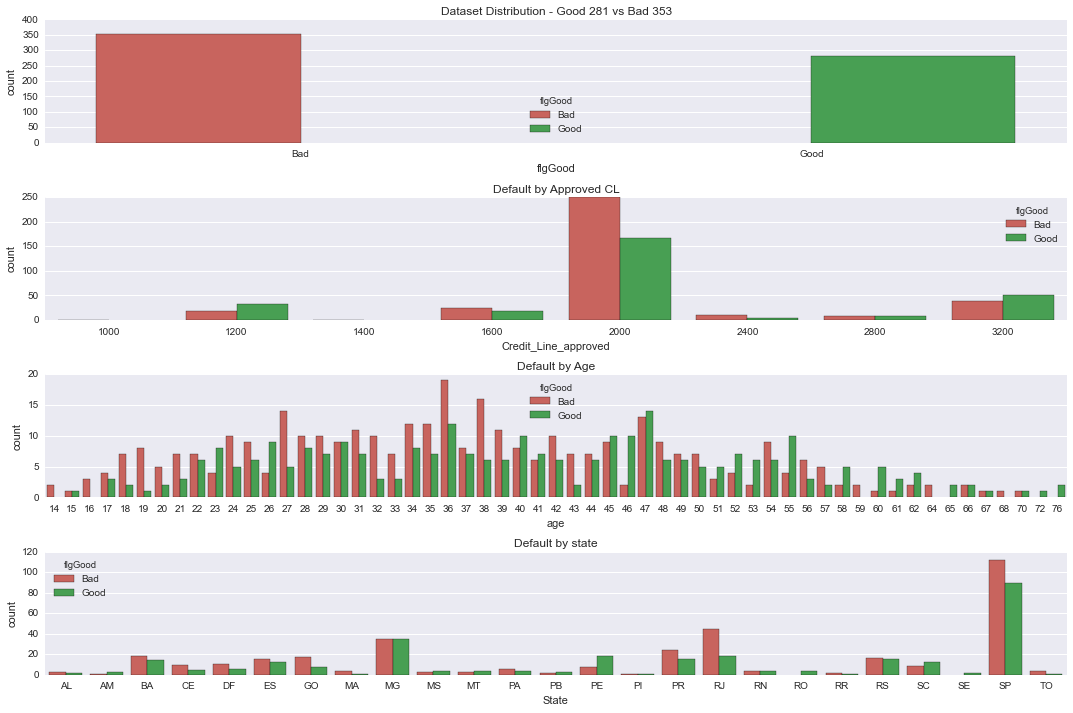

In [8]:
nr_bad = data[data.flgGood=='Bad']['customer_id'].count()
nr_good = data[data.flgGood=='Good']['customer_id'].count()
title = 'Dataset Distribution - Good {} vs Bad {}'.format(nr_good, nr_bad)
f, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15, 10))
ax1.set(title=title)
sns.countplot(x='flgGood', data=data.sort(['age']), hue='flgGood', palette=myPalette, ax=ax1)
ax2.set(title='Default by Approved CL')
sns.countplot(x='Credit_Line_approved', data=data.sort(['Credit_Line_approved','flgGood']), hue='flgGood', palette=myPalette, ax=ax2)
ax3.set(title='Default by Age')
sns.countplot(x='age', data=data.sort(['age','flgGood']), hue='flgGood', palette=myPalette, ax=ax3)
ax4.set(title='Default by state')
sns.countplot(x='State', data=data.sort(['State','flgGood']), hue='flgGood', palette=myPalette, ax=ax4)

plt.tight_layout()

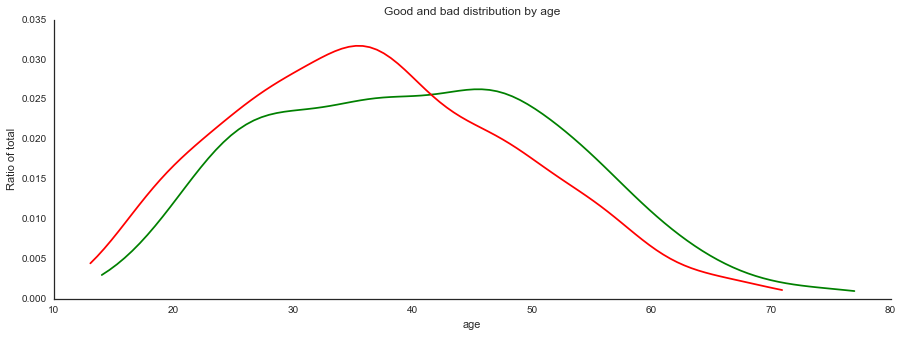

In [9]:
sns.set_style("white")
f, ax1 = plt.subplots(1,1, figsize=(15, 5))
ax1.set(title='Good and bad distribution by age')
ax1.set_ylabel('Ratio of total')
sns.distplot(data.age[data.flgGood=='Good'], ax=ax1, color='g', hist=False)
sns.distplot(data.age[data.flgGood=='Bad'], ax=ax1, color='r', hist=False)
sns.despine()

###Conclusions:
    
    - Most of the states maintain the relation of having more bad than good payers
    - SC,PE, MG, MT, MS e PB have more good payers
    - Over 45 are better payers and below 39 are worst payers
    - 2000 is the most approved credit and have the worst payers. Credit approved above 2800 have less defaulters
    - There are people below 18 with credit cards. Is that possible??

# Wages
Is there any relations between wages and age? And total spend with default?

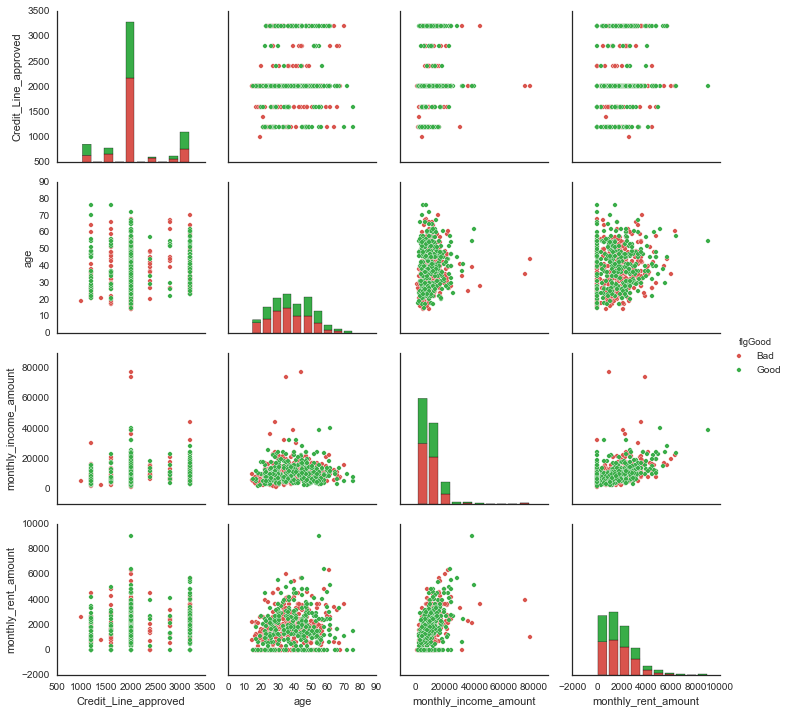

In [10]:
wages = pd.DataFrame(dict(
        monthly_income_amount = data[u'monthly_income_amount'],
        monthly_rent_amount = data[u'monthly_rent_amount'],
        Credit_Line_approved = data[u'Credit_Line_approved'],
        age=data[u'age']) )
wages = pd.concat([wages, data['flgGood']], axis = 1)
g = sns.pairplot(wages.sort('flgGood'), hue="flgGood", palette=myPalette)       

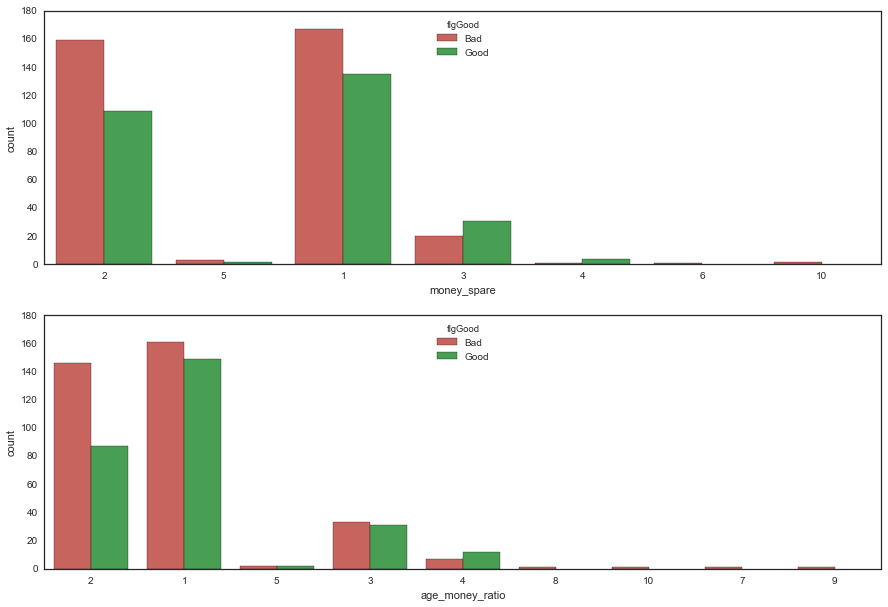

In [14]:
wages['money_spare'] = mu.binarize(data[u'monthly_income_amount']-data[u'monthly_rent_amount']-data[u'Credit_Line_approved'])
wages['age_money_ratio'] = mu.binarize(data[u'monthly_income_amount']/data[u'age'])

f, (ax1, ax2) = plt.subplots(2,1, figsize=(15, 10))
sns.countplot(x='money_spare', data=wages.sort('flgGood'), hue='flgGood',palette=myPalette, ax=ax1)
sns.countplot(x='age_money_ratio', data=wages.sort('flgGood'), hue='flgGood',palette=myPalette, ax=ax2)

###Conclusions:
    
    - There are some outliers that are probably mistakes when typing, as they earn a lot of money
    - the ones that have more money to spare (total income minus expenses like rent and credit card) pay a little better
    - more money proportionally to the age tend to pay better. But the biggest differences are probably errors

## Scores

Are the scores given by other entities good? Do they guarantee good payment?

In [15]:
cols = [u'raw_serasa_score', u'raw_unit4_score',
        u'raw_lexisnexis_score',u'raw_TU_score', u'raw_FICO_money_score']
# create bins of the scores
raw_scores_bin = pd.DataFrame(dict(
        raw_serasa_score = mu.binarize(data[u'raw_serasa_score']),
        raw_unit4_score = mu.binarize(data[u'raw_unit4_score']),
        raw_lexisnexis_score = mu.binarize(data[u'raw_lexisnexis_score']),
        raw_TU_score = mu.binarize(data[u'raw_TU_score']),
        raw_FICO_money_score = mu.binarize(data[u'raw_FICO_money_score'])))
raw_scores = pd.concat([raw_scores_bin, data['flgGood']], axis = 1)

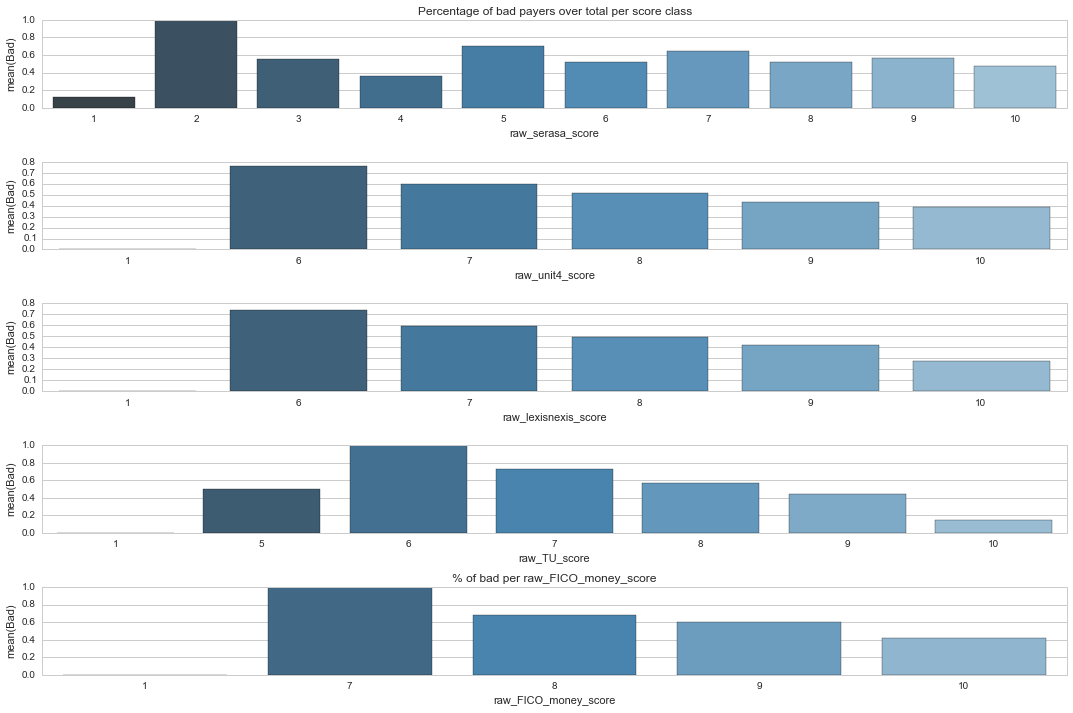

In [16]:
sns.set_style("whitegrid")
f, ax_list = plt.subplots(5,1, figsize=(15, 10))
ax_list[0].set(title='Percentage of bad payers over total per score class')
for col, ax in zip(cols,ax_list):
    # check if indeed bigger scores, less default
    per_default = raw_scores.groupby([col, 'flgGood'])['flgGood'].count().unstack().fillna(0)
    per_default = per_default.apply(lambda l: [float(l[0])/sum(l), float(l[1])/sum(l)] , axis=1)
    plt.title('% of bad per {}'.format(col))
    sns.barplot(per_default.index, per_default.Bad, palette="Blues_d", ax = ax)
plt.tight_layout()

###Conclusions
    
    - The higher the score, less chance of default.
    - Serasa score is not a very good indicative.
    - there are outliers with low scores

## Data distribution and correlation

Checking the deistributions and correlations

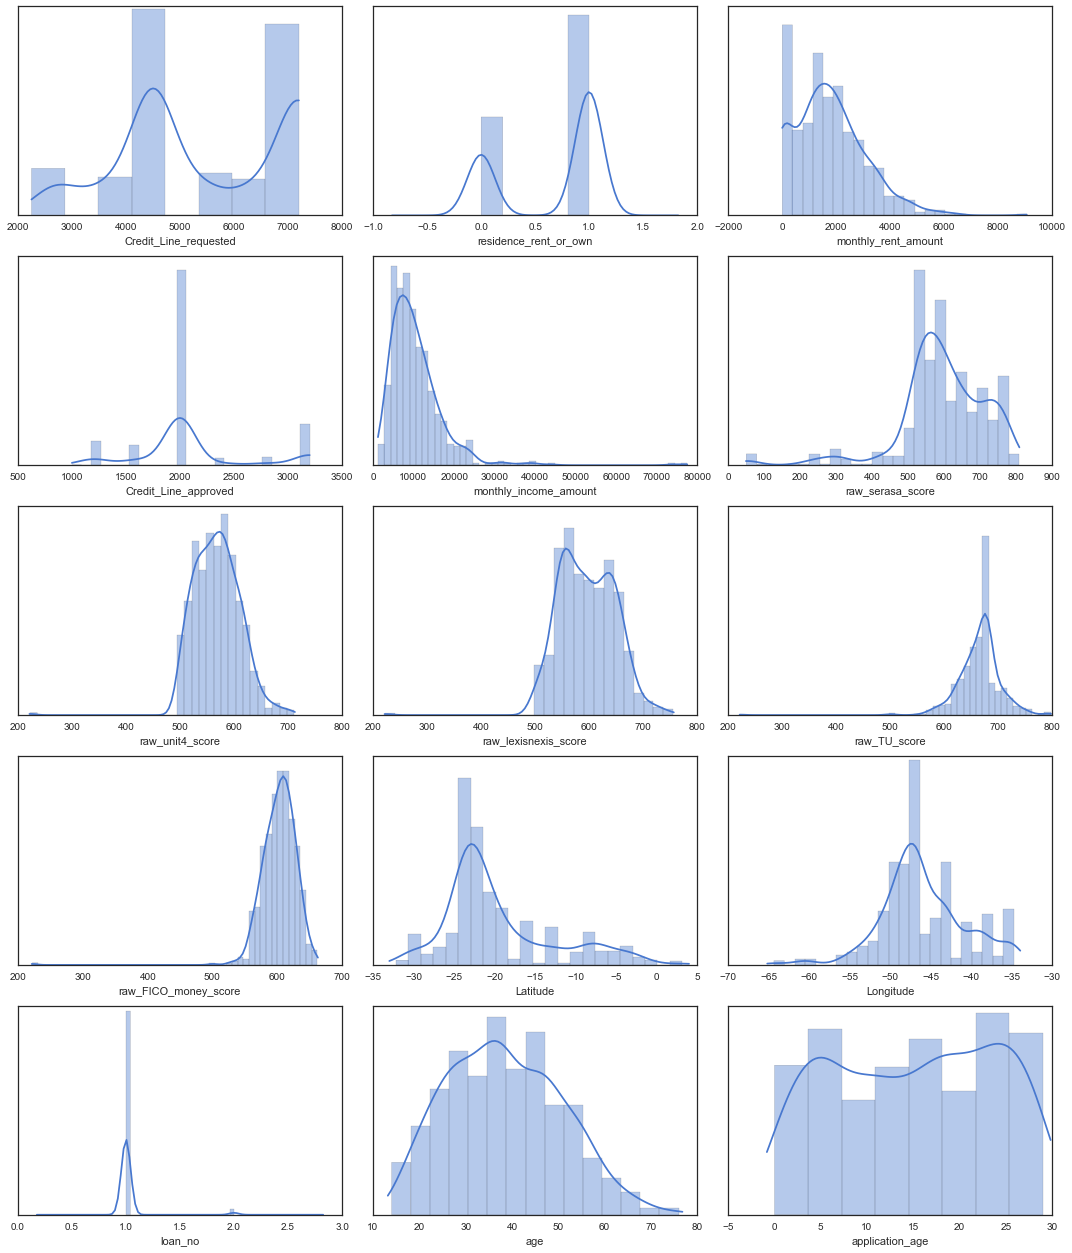

In [17]:
mu.print_distributions(data)

In [18]:
# columns helpers to print data
data_cols = data.columns.difference(['flgGood'])
numeric_cols = data._get_numeric_data().columns
non_numeric_cols = data.columns.difference(numeric_cols).difference(['flgGood'])

/usr/local/lib/python2.7/site-packages/seaborn/linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/usr/local/lib/python2.7/site-packages/seaborn/linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


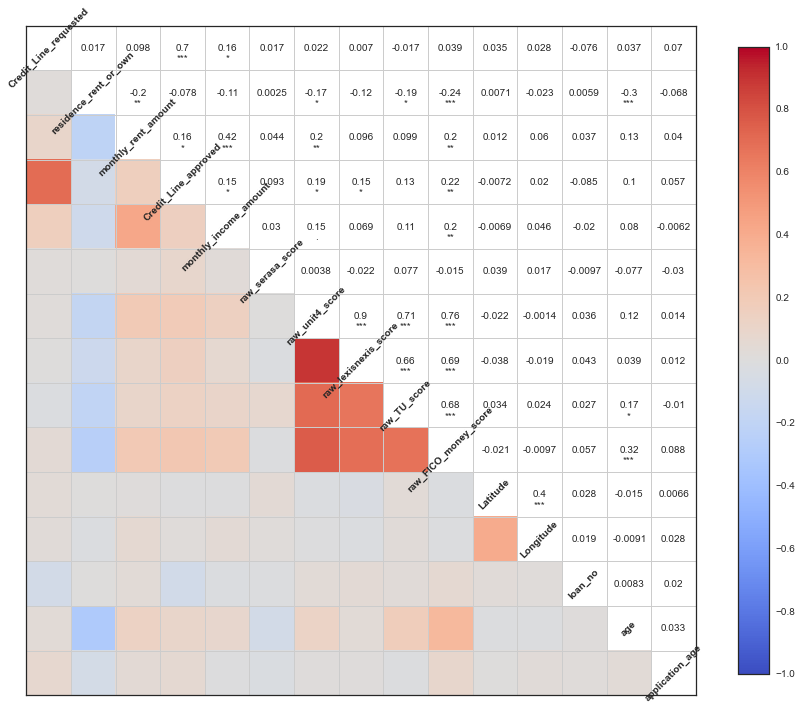

In [19]:
# correlations
f, ax = plt.subplots(figsize=(15, 15))
sns.corrplot(data[numeric_cols])